In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : Hs-d1PUT 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

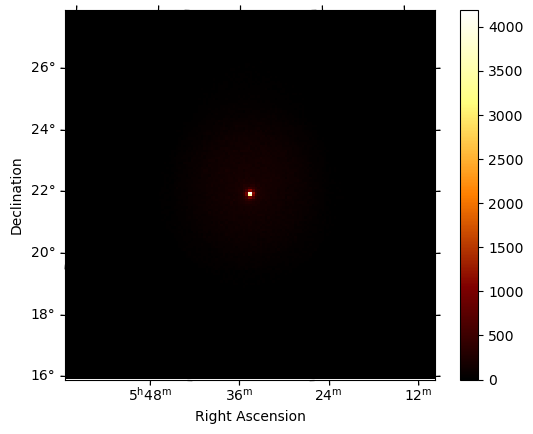

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'

shift = -0.01
tilt = -0.015


In [22]:
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift, 
                        tilt = tilt,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix





In [23]:
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N]) 

In [8]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [9]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

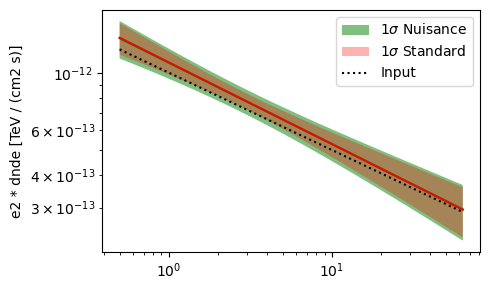

In [18]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red", alpha = 0.9)    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.3)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [19]:
compute_fluxpoints = 1
if compute_fluxpoints:
    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_asimov = esti.run([dataset_asimov])
    fluxpoints_asimov.write("data/6_fluxpoints_asimov.fits", overwrite = True)
else:
    fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits", )
    

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.995022627659147 1.2680254808109492
norm 0.9957476868913879 0.4825297424247557
norm 0.9964533689289892 0.24386838818304804
norm 0.9968550149954144 0.20813425770586727
norm 0.9974232331541456 0.20736475614862843
norm 0.9979865241785522 0.2129831726236554
norm 0.9985570322004969 0.22529857119497224
norm 0.9991522111108503 0.24326863351150954
norm 0.9997303918632905 0.26123295430649646
norm 1.000320161702565 0.28617146256753623
norm 1.000896285752333 0.3184687001473034
norm 1.0014549891704725 0.35463952941335797
norm 1.0020070787069073 0.399521757822576
norm 1.0025544166178908 0.4528475434553318
norm 1.0031006314165432 0.508162783859836
norm 1.003850495032827 0.5744838721878304
norm 1.0044231252540485 0.6608255627848608
norm 1.0046385971455531 0.7874896922567701
norm 1.0 0


In [24]:
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    ## modify the covariance matrix, because only one nuisance parameter here
    #penalising_covmatrix = [[1/sigma_a**2]]
    #penalising_invcovmatrix =  penalising_covmatrix
    #dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
    with dataset_asimov_N.models.restore_status():
        dataset_asimov_N.models.parameters.freeze_all()
        dataset_asimov_N.models.parameters['norm_nuisance'].frozen = False
        dataset_asimov_N.models.parameters['tilt_nuisance'].frozen = False
        fluxpoints_asimov_N = esti_N.run(dataset_asimov_N)

    fluxpoints_asimov_N.write("data/6_fluxpoints_asimov_N.fits", overwrite = True)
else:
    fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits",)
    

norm 1.0 0
norm_nuisance 0.0005255024817342704 0.08309390489155252
tilt_nuisance -6.584272993881849e-05 0.014897584765013816
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 0.0005255024817342704 0.08309390489155252
tilt_nuisance -6.584272993881849e-05 0.014897584765013816
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 0.0005255024817342704 0.08309390489155252
tilt_nuisance -6.584272993881849e-05 0.014897584765013816
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 0.0005255024817342704 0.08309390489155252
tilt_nuisance -6.584272993881849e-05 0.014897584765013816
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 0.0005255024817342704 0.08309390489155252
tilt_nuisance -6.584272993881849e

In [25]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

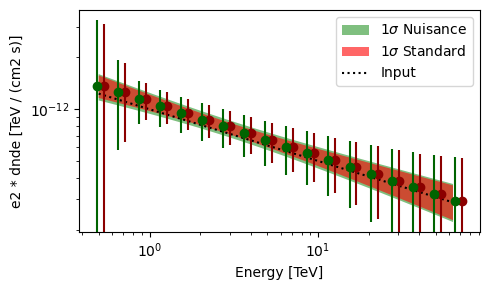

In [26]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_asimov."+ picformat)
